# Overview

This workbook illustrates text clustering in Python (using mainly sklearn framework).

The data consists of ~5k texts (web articles) with tech content, clustered in ~ 480 categories (the data file is attached as "data.csv"). The goal is to cluster these articles possibly close to the original labels provided.

While there is quite a lot web tutorials on text classification and clustering, this demo shows also presents some less common tricks.

The main finding is that the bag-of-words model (counting keywords frequencies) works pretty well when couppled with few tricks.
Ignoring stopwords and stemming temrs helps to choose selective and non-redundant keywords.
Dimensionality-reduction techniques are necessary, because of too many keywords (a consequence of many clusters). Also, for better peformance, we combine knowledge extracted from titles and full texts in a non-symmetric way (weighted average of two modeles).

Interestingly, more advanced text processing techniques (ngrams, lemmatization) and information-theoretic methods of choosing keywords (chi2 or entropy) don't help much. This is probably due to the specific content of articles - being related to modern technologies, they are likely to be classified better with single keywords than with phrases and other grammatical variations.

The presented solution achieves ~ 75% of accuracy (as measured by ARI), when compared with the original labelling.

Getting much higher performance may be more complicated, because of highly inbalanced data - many clusters are too small to learn.


# Python code

### Libraries

In [2]:
import string

import os
import pandas as pnd
import numpy as np
import sklearn
import math

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import metrics

import re
import nltk 
import spacy # note: make sure that spacy is installed properly!

from sklearn.decomposition import TruncatedSVD

from scipy.stats import entropy

import matplotlib.pyplot as plt

## Preprocessing

In [3]:
### DATA EXTRACTION ###
data = pnd.read_csv('data.csv', header=0)
data.loc[:10]
# structure: article_id, cluster_id, title, content

,cid,title,text
0,0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
1,0,Samsung to Showcase Three Creative Lab Project...,Samsung Electronics announced that it will be ...
2,0,OrCam's MyMe wearable will watch and decode th...,You've probably heard of wearable cameras from...
3,0,It’s an Unobtrusive Assistant Whispering in Yo...,PhotoThe OrCam MyMe speaks to the user through...
4,0,Drones look set to take centre stage at CES 2016,Drones or unmanned aerial vehicles (UAVs) have...
5,0,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
6,0,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k..."
7,0,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...
8,0,CES 2016: What To Expect,The Earth has just about completed another orb...
9,0,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...


In [4]:
### DATA CLEANSING ###

# grund truth - original labels will be used for evaluation
y_train = data['cid']
# training data
X_train = data.drop('cid',axis=1)
data.loc[:10]

,cid,title,text
0,0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
1,0,Samsung to Showcase Three Creative Lab Project...,Samsung Electronics announced that it will be ...
2,0,OrCam's MyMe wearable will watch and decode th...,You've probably heard of wearable cameras from...
3,0,It’s an Unobtrusive Assistant Whispering in Yo...,PhotoThe OrCam MyMe speaks to the user through...
4,0,Drones look set to take centre stage at CES 2016,Drones or unmanned aerial vehicles (UAVs) have...
5,0,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
6,0,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k..."
7,0,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...
8,0,CES 2016: What To Expect,The Earth has just about completed another orb...
9,0,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...


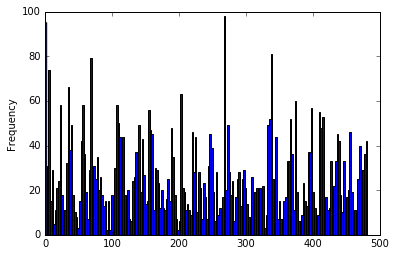

We have 322 classes of size >=5, which covers=92.16% of data


In [5]:
# Labels distribition - note it is highly inbalanced !

data['cid'].plot.hist(200)
plt.show()

min_class_size = 5
class_counts = pnd.crosstab(data['cid'],1)
print("We have %d classes of size >=%s, which covers=%s%% of data" % (np.float((class_counts>=min_class_size).sum()), min_class_size, 100*np.float( class_counts[class_counts>=min_class_size].sum()/len(data) )) )


## Simple model: Bag-of-words from title + KMeans clustering

In [6]:
## BAG-OF-WORDS MODEL ##

# create the term-document matrix, counting occurencies of words in documents; english stop-words are skipped!
count_vect = CountVectorizer(stop_words='english')
X_train_f = count_vect.fit_transform(X_train['title'])

# note the term-document matrix is sparse
print("sparse compression = %.4f" % ((X_train_f>0).sum()/(X_train_f.shape[0]*X_train_f.shape[1])))

sparse compression = 0.0013


In [7]:
# IDF transform reweight frequencies, to prefer more selective (=less common) terms
tfidf_transformer = TfidfTransformer().fit(X_train_f)
X_train_idf = tfidf_transformer.transform(X_train_f)

In [8]:
## KMeans Clustering ##

# the number of clusters known from the 'grund truth' labels
N = y_train.unique().shape[0]
clstr = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs=-1)
clstr.fit(X_train_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=482, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Model Evaluation

In [9]:
## Evaluation

# compare with 'grund truth' labels; use information-theoretic metrics robust against the 'dimensionality curse'
def cluster_metrics(clstr):
    d = {}
    d["V-Measure"] = metrics.v_measure_score(y_train, clstr.labels_)
    d["Adjusted Rand Index"] =metrics.adjusted_rand_score(y_train, clstr.labels_)
    return d
cluster_metrics(clstr)

{'Adjusted Rand Index': 0.33031321967812965, 'V-Measure': 0.83599583844413083}

In [10]:
## Example - the first row cluster

labels = clstr.labels_
centers = clstr.cluster_centers_
features = np.array(count_vect.get_feature_names())
print("top keywords: %s"%",".join(features[centers[labels[0]].argsort()[-10:]]))
X_train[labels==labels[0]]
# makes sense, but far from perfect

top keywords: smart,guide,drone,tech,panasonic,best,look,expect,2016,ces


,title,text
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
4,Drones look set to take centre stage at CES 2016,Drones or unmanned aerial vehicles (UAVs) have...
5,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
8,CES 2016: What To Expect,The Earth has just about completed another orb...
9,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...
13,What to Look for at CES 2016,"Not too many years ago, the primary focal poin..."
14,CES 2016: What to expect from the Las Vegas te...,"Ready or not, the annual Consumer Electronics ..."


## Extensions and optimization

### Clustering on full texts

In [11]:
clstr = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11)),
])

clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# ari ~ 59.8%, much better! but the term-document matrix is still huge (too many keywords)
print("Words used: %s"%len(clstr.steps[0][1].vocabulary_))

{'Adjusted Rand Index': 0.59848939456267203, 'V-Measure': 0.90585739652935349}
Words used: 39024


In [12]:
def show_cluster(row, show_words=True, show_table=True):
    km =  clstr.steps[2][1]
    vect = clstr.steps[0][1]
    cid = km.labels_[row]
    centers = km.cluster_centers_
    features = np.array(vect.get_feature_names())
    if show_words:
        print("top keywords: %s"%",".join(features[centers[cid].argsort()[-20:]]))
    if show_table:
        return X_train[km.labels_==cid][['title','text']]
    else:
        return 

show_cluster(151)
# the cluster and keywords look more accurate, comparing to the previous attempt :-)

top keywords: their,attack,you,charney,mean,that,attacks,users,evidence,to,and,state,targeted,accounts,the,sponsored,your,compromised,account,microsoft


,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
158,Microsoft will alert users of state-sponsored ...,"Microsoft is joining Google, Yahoo and Faceboo..."
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
160,Microsoft to Notify Users of State-Sponsored A...,Microsoft will now notify users if it believes...
161,Microsoft To Begin Warning Email Users Of Susp...,"With the announcement, the company will take t..."
162,Microsoft to Inform Users of Government Spying,Microsoft Corporation assured users that it is...
163,Microsoft pledges to inform users of state sur...,Microsoft has pledged to inform users if their...
171,Microsoft to Alert Users to Suspected Governme...,Microsoft Corp. said it plans to begin informi...
173,Microsoft will now alert you if your account i...,Microsoft has announced on the official compan...
174,Microsoft to alert users if their account gets...,"Last night, Microsoft announced the company wi..."


### Stopwords, Stemming (token-level analysis)

In [13]:
# we shall remove english stopwords like their, your... they are not informative as keywords

clstr.set_params(vect__stop_words='english')
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# ari ~ 63.2%, much better! 
print("Words used: %s"%len(clstr.steps[0][1].vocabulary_))
show_cluster(151,show_table=False)

{'Adjusted Rand Index': 0.6324059412840034, 'V-Measure': 0.91156349983240903}
Words used: 38722
top keywords: attacker,email,step,notifications,password,suspicious,notify,evidence,malware,secure,attacks,mean,sponsored,state,users,targeted,accounts,compromised,account,microsoft


In [14]:
# stemming converts (heuristically) words to root forms - removing redundancy ("attack,attacks,attacker -> attack")

stemmer = nltk.stem.PorterStemmer() # assume documents are in english 
pattern = r'\b(?u)\w\w+\b' # assume keywords are alpha-numeric words of length 2 
pattern = re.compile(pattern)
def tokenize(text):
    # custom tokenize function
    text = text.translate(string.punctuation)
    tokens = pattern.findall(text)
    tokens_filtered = [stemmer.stem(t) for t in tokens]
    return tokens_filtered

clstr.set_params(vect__tokenizer=tokenize)
clstr.set_params(vect__strip_accents='unicode')
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
print("Words used: %s"%len(clstr.steps[0][1].vocabulary_))
# ari ~ 63.8% and the vocabulary reduced!

show_cluster(151,show_table=False)
# note that redundant keywords disappeared

{'Adjusted Rand Index': 0.63768926391862213, 'V-Measure': 0.91378284750127381}
Words used: 26909
top keywords: suspici,malwar,hack,mean,email,notifi,password,notif,secur,step,charney,user,evid,target,state,sponsor,compromis,attack,microsoft,account


### Ignore very rare terms (feature selection)

In [ ]:
# idea: skip terms with very low frequencies (e.g. <5), this makes the matrix smaller and speeds up computations

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5,tokenizer=tokenize,strip_accents='unicode',stop_words='english')),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

clstr.fit_transform(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
print("Words used: %s"%len(clstr.steps[0][1].vocabulary_))
# ari ~ 64.7%, much better and the term-document matrix is now small
vocabulary = list(clstr.steps[0][1].vocabulary_.keys()) # keep the vocabulary for future use

show_cluster(151)

In [294]:
# we can use the precomputed vocabulary

clstr = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,strip_accents='unicode',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

clstr.fit_transform(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))

{'ari': 0.64721972876425726, 'v': 0.91388384359105634}
Words before tokenization: 9048
Words after tokenization: 9048


In [295]:
clstr.steps[0][1]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7f7927d50d90>,
        vocabulary=['107', '14nm', 'disengag', 'counterpoint', 'curat', 'gou', 'unabl', 'wife', 'capabl', 'open', 'bumpi', 'standalon', '300', 'propag', 'piano', 'frequent', 'islamist', 'bolder', 'warehous', 'summari', 'cia', 'weigh', 'botnet', 'disadvantag', 'greatest', 'fanci', 'north', 'extens', 'hate', ...disturb', 'astonish', 'sentient', 'classic', 'skycontrol', 'cablevis', 'syria', 'searchabl', '1500'])

### Lemmatization, NGrams (advanced token-level analysis)

In [18]:
# one can form tokens from "n" consecutive words - so called n-grams, which is more likely to catch phrases

# note: it may take long!

clstr.set_params(vect__ngram_range=(1,2))
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# but it didn't help :-( probably, phrases are not that selective for tech-content, as single words
clstr.set_params(vect__ngram_range=(1,1))

KeyboardInterrupt: 

In [301]:
# another interesting trick is to do lemmatizing - which is a deeper (grammar-aware) analysis of words 

# note: it may take long!

lemmatizer = spacy.load("en")

def lemmatize(text):
   	# custom tokenize function
    text = text.translate(string.punctuation)
    tokens = pattern.findall(text)
    lemmas = lemmatizer(text)
    tokens_filtered = [t.lemma_ for t in lemmas]
    return tokens_filtered

print(lemmatize("It's going better and better")) # example

clstr.set_params(vect__tokenizer=lemmatize)
clstr.fit(X_train['text'])
print(cluster_metrics(clstr.steps[2][1]))
# but it didn't help :-( probably most selective keywords are nouns, and linguistic games are not necessary
clstr = clstr.set_params(vect__tokenizer=tokenize)

['-PRON-', 'be', 'go', 'good', 'and', 'good']
{'ari': 0.59083826976662424, 'v': 0.90111572318543809}


Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...482, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=11, tol=0.0001, verbose=0))])

### Concatenate titles and texts (feature ingeneering)

In [275]:
# we shall use both text and titles (titles may contain our keywords). 

# to demonstrate it works we concatenate, later we will combine them in a different way

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5,stop_words='english')),
            ('tfidf', TfidfTransformer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1,n_jobs=-1, random_state=11))
])

X_train['alltext'] = X_train['text']+X_train['title']
clstr.fit(X_train['alltext'])
print(cluster_metrics(clstr.steps[2][1]))
# ari ~ 65.1% which is better! 

{'ari': 0.65101723036386638, 'v': 0.91949566978819963}


### Words preselection (feature selection)

In [73]:
# idea: select terms most informative about the class distribution (ground truth labels) 
# to evaluate information gain, use information-theoretic metrics like mutual information or chi2

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5,stop_words = 'english')),
            ('tfidf', TfidfTransformer()),
            ('feature_select',SelectKBest(chi2,k=5000)),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs = -1, random_state=11)),
])

clstr.fit(X_train['text'],y_train)
print(cluster_metrics(clstr.steps[3][1]))

# didn't work well :-( 
# a) the approach is greedy and may select many correlated attributes that maximize information
# b) we have many classes and don't expect to massively reduce the number of keywords involved

{'ari': 0.41135571087816902, 'v': 0.89274849054885808}


### Latent Semantic Analysis (dimension reduction)

In [16]:
# idea: approximate data by a linear low-dimensional object (by means of Singular Value Decomposition). for text clusteting one uses 100-200 dimensions
# note: all feetures may contribute to this transformation, as opposed to the previous approach

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5, stop_words = 'english')),
            ('tfidf', TfidfTransformer()),
            ('svd', TruncatedSVD(random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr', KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=1, n_jobs = -1, random_state=11)),
])
# tunning the svd dimension 
for dim in [100,150,200,250]:
    clstr.set_params(svd__n_components=dim)
    clstr.fit(X_train['text'])
    print("n_dimensions=%s,results=%s"%(dim,cluster_metrics(clstr.steps[4][1])))

# ari ~ 70%, improved :-)

n_dimensions=100,results={'ari': 0.66553497838887543, 'v': 0.91381604330571742}
n_dimensions=150,results={'ari': 0.68679826644428787, 'v': 0.92076921209944718}
n_dimensions=200,results={'ari': 0.70252954856867411, 'v': 0.92424160319266113}
n_dimensions=250,results={'ari': 0.68698731032201699, 'v': 0.92417012450216673}


### Hierarchical Clustering Algorithm

In [157]:
# AgglomerativeClustering merges cluster iteratively (aka rich gets richer)

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5, stop_words='english', vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer()),
            ('svd', TruncatedSVD(n_components=150, random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
])
clstr.fit(X_train['text'])
print("results=%s"%(cluster_metrics(clstr.steps[4][1])))
# ari ~ 71.7%, improved :-) 

results={'ari': 0.71747116194587146, 'v': 0.92837353625649999}


In [101]:
# illustrate the results - show the cluster of the first row
labels = clstr.steps[4][1].labels_
X_train[labels==labels[0]][['title','text']]

,title,text,alltext
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...,"Here's what to expect at CES 2016 this week,We..."
6,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k...","CES 2016: Smart homes, smart cars, virtual rea..."
7,What ever happened to last year's Best of CES ...,What happens in Vegas stays in Vegas -- and th...,What ever happened to last year's Best of CES ...
8,CES 2016: What To Expect,The Earth has just about completed another orb...,"CES 2016: What To Expect,The Earth has just ab..."
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...,"A Glance at Highs, Lows of CES 2015,Consumer E..."
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...,The DeanBeat: Our preview of next week’s CES 2...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...,"What to expect from CES in 2016,In just a few ..."
13,What to Look for at CES 2016,"Not too many years ago, the primary focal poin...","What to Look for at CES 2016,Not too many year..."
14,CES 2016: What to expect from the Las Vegas te...,"Ready or not, the annual Consumer Electronics ...",CES 2016: What to expect from the Las Vegas te...
15,CES 2016 guide: How to survive the madness,Surviving the Consumer Electronics Show is no ...,"CES 2016 guide: How to survive the madness,Sur..."


In [102]:
# test the performance when clustering on all text data
clstr.fit(X_train['alltext'])
print("results=%s"%(cluster_metrics(clstr.steps[4][1])))
# ari ~ 72.7%, better :-) 

results={'ari': 0.73257288486151317, 'v': 0.93182534506432524}


### Similarity Metrics (connectivity constraints)

In [87]:
# cosine distance is an effective similarity measure of (vectorized representations of) documents

clstr = Pipeline([
            ('vect', CountVectorizer(min_df=5, stop_words='english',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer())
])
X_train_idf = clstr.fit_transform(X_train['text'])
dist = 1 - metrics.pairwise.cosine_similarity(X_train_idf)
# see top 20 documents related to the first row
X_train.loc[sorted( dist[0,:].argsort()[:20] )]

,title,text
0,Here's what to expect at CES 2016 this week,We are on the eve of the year's biggest techno...
5,3 Drone Start-Ups to Look out for at CES 2016,The start of 2016 means start of the biggest t...
6,"CES 2016: Smart homes, smart cars, virtual rea...","The International Consumer Electronics Show, k..."
8,CES 2016: What To Expect,The Earth has just about completed another orb...
9,Car Tech: What to Expect at CES 2016,I've gone to Las Vegas for CES every January s...
10,"A Glance at Highs, Lows of CES 2015",Consumer Electronics Show (CES) has markedly c...
11,The DeanBeat: Our preview of next week’s CES 2...,I made my predictions last week about what wil...
12,What to expect from CES in 2016,In just a few days the Engadget team will be g...
13,What to Look for at CES 2016,"Not too many years ago, the primary focal poin..."
14,CES 2016: What to expect from the Las Vegas te...,"Ready or not, the annual Consumer Electronics ..."


In [ ]:
# we can use it to put "connectivity" constraints on the clustered data, e.g. only "close" points can be clustered



### Number of clusters

In [110]:
clstr.set_params(clstr__n_clusters=400)
clstr.fit(X_train['alltext'])
print("results=%s"%(cluster_metrics(clstr.steps[4][1])))
# ari ~ 73.3%, improved :-) 

# the right number should be bigger than 400

results={'ari': 0.73263655314805209, 'v': 0.93143703398985034}


### Weighted title+text model (feature engineering)

In [281]:
# build separate models for text and title, and average by weights

clstr = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,strip_accents='unicode',vocabulary=vocabulary)),
            ('tfidf', TfidfTransformer())
])
X_train_idf1 = clstr.fit_transform(X_train['text'])
X_train_idf2 = clstr.fit_transform(X_train['title'])

X_train_idf = 2*X_train_idf1 + 1*X_train_idf2 # text gets bigger weights !

clstr = Pipeline([
           	('svd', TruncatedSVD(n_components=200, random_state=11)),     
            ('normalizer', Normalizer()),
            ('clstr',AgglomerativeClustering(n_clusters=N,linkage='ward'))
])
clstr.fit(X_train_idf)
print("results=%s"%(cluster_metrics(clstr.steps[2][1])))
# ari ~ 74.6%, improved :-)


results={'ari': 0.74626686427471167, 'v': 0.93654519194603059}


In [282]:
clstr.set_params(clstr__n_clusters=400)
clstr.fit(X_train_idf)
print("results=%s"%(cluster_metrics(clstr.steps[2][1])))
# ari score ~ 75.3% :-)

results={'ari': 0.75286880883258145, 'v': 0.93555184285621329}


In [283]:
# illustrate the results - show the cluster about internet security issues
labels = clstr.steps[2][1].labels_
X_train[labels==labels[159]][['title','text']]

,title,text
151,Additional steps to help keep your personal in...,We’re committed to helping our users keep thei...
152,Exclusive: Microsoft to warn email users of su...,A Microsoft logo is seen at a pop-up site for ...
153,Microsoft Will Warn Users of 'State-Sponsored'...,The tech industry’s role in government surveil...
154,"Yahoo mimics Facebook, Google with 'state-spon...",Yahoo last week followed the lead of rivals Fa...
155,Microsoft To Notify If Government is Trying to...,Microsoft will now be informing users of any s...
156,Microsoft to start alerting users of suspected...,Microsoft announced Wednesday that it would be...
157,Microsoft will notify users of suspected gover...,Microsoft said Wednesday night that it will te...
158,Microsoft will alert users of state-sponsored ...,"Microsoft is joining Google, Yahoo and Faceboo..."
159,Microsoft to Warn Users of State-Sponsored Att...,Microsoft on Wednesday announced plans to info...
160,Microsoft to Notify Users of State-Sponsored A...,Microsoft will now notify users if it believes...
